## Data Loading & Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r"C:\Users\Asus\Downloads\WA_Fn-UseC_-Telco-Customer-Churn.csv"

print("--- Step 1: Data Loading ---")
try:
    # Most Customer Churn datasets are CSV files
    df = pd.read_csv(file_path)
    
    print(f" Data file successfully loaded. Total customers: {len(df)}")
except FileNotFoundError:
    print(f" Error: File not found at '{file_path}'. Please check the path.")
    exit()

# 2. Initial Inspection
print("\n--- Initial Inspection (Head & Info) ---")
print(df.head())
print(df.info()) # Check for missing values and data types

print("\n--- Target Variable Distribution (Churn) ---")
# The 'Churn' column (usually Yes/No or 1/0) is the target variable
print(df['Churn'].value_counts())

# Calculate the churn rate
churn_count = df['Churn'].value_counts().get('Yes', df['Churn'].value_counts().get(1, 0))
total_count = len(df)
churn_rate = (churn_count / total_count) * 100

print(f"\nChurned customers: {churn_count}")
print(f"Churn Rate: {churn_rate:.2f}%")

--- Step 1: Data Loading ---
 Data file successfully loaded. Total customers: 7043

--- Initial Inspection (Head & Info) ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4             

C:\Users\Asus\AppData\Local\Temp\ipykernel_18268\686059100.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  churn_count = df['Churn'].value_counts().get('Yes', df['Churn'].value_counts().get(1, 0))


## Data Preprocessing & Feature Engineering

In [2]:
# 'TotalCharges' ko numerical mein convert karna. Errors='coerce' se non-numeric values NaN ho jayengi.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for NaN values created by coercion
print("--- Missing Values check (after conversion) ---")
print(df.isnull().sum())

# Missing Values ko handle karna: Kyunki TotalCharges mein sirf 11 missing values hain 
# (Total 7043 mein se), hum unhe 0 se replace kar sakte hain (kyunki tenure=0 hoga).
df['TotalCharges'].fillna(0, inplace=True) 

print("\n TotalCharges successfully converted to numeric and NaN values handled.")

--- Missing Values check (after conversion) ---
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

 TotalCharges successfully converted to numeric and NaN values handled.


C:\Users\Asus\AppData\Local\Temp\ipykernel_18268\4083760448.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


#### 2. Feature Engineering & Selection

In [4]:
# Drop Customer ID
df = df.drop('customerID', axis=1)

# Encode Target Variable (Churn: Yes=1, No=0)
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})
print(" Target variable 'Churn' encoded to 1/0.")

 Target variable 'Churn' encoded to 1/0.


C:\Users\Asus\AppData\Local\Temp\ipykernel_18268\2466112880.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})


#### 3. One-Hot Encoding (Categorical Variables)

In [5]:
# Identify categorical columns (object type, excluding Churn which is now int)
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Apply One-Hot Encoding
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\n--- Processed Data Head (after One-Hot Encoding) ---")
print(df_processed.head())
print(f"Total features after encoding: {df_processed.shape[1] - 1}")


--- Processed Data Head (after One-Hot Encoding) ---
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0        False   
1              0      34           56.95       1889.50      0         True   
2              0       2           53.85        108.15      1         True   
3              0      45           42.30       1840.75      0         True   
4              0       2           70.70        151.65      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3        False           False             False   
4        False           False              True   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                            True  ...                            False   
1             

## Model Training (XGBoost)

#### 1. Data Splitting

In [6]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# X = Features (all columns except 'Churn')
# y = Target ('Churn')
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Split the data into Training and Testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y # Imbalance ko train/test sets mein maintain karein
)

print(f"Data successfully split. Training set size: {len(X_train)} samples. Testing set size: {len(X_test)} samples.")

Data successfully split. Training set size: 4930 samples. Testing set size: 2113 samples.


#### XGBoost Model Training (Handling Imbalance)

In [7]:
# Calculate the scale_pos_weight
neg_count = y_train.value_counts()[0]  # Non-Churn (0) count
pos_count = y_train.value_counts()[1]  # Churn (1) count
scale_pos_weight_value = neg_count / pos_count

print(f"\nCalculated scale_pos_weight: {scale_pos_weight_value:.2f}")

# Initialize XGBoost Classifier
# use_label_encoder=False (modern practice)
# eval_metric='logloss' (for classification)
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_value, # Imbalance handling
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
print("\nTraining XGBoost Model...")
xgb_model.fit(X_train, y_train)
print(" XGBoost Model successfully trained.")


Calculated scale_pos_weight: 2.77

Training XGBoost Model...
 XGBoost Model successfully trained.


C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [15:33:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Prediction, Evaluation & Feature Importance

#### 1. Prediction

In [8]:
# Predictions on the test set
print("\nMaking predictions on the Test Set...")
y_pred_xgb = xgb_model.predict(X_test)

# Prediction probabilities for ROC curve (optional but good practice)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(" Predictions completed.")


Making predictions on the Test Set...
 Predictions completed.


#### 2. Evaluation Metrics

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

print("\n--- Confusion Matrix (XGBoost) ---")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)

print("\n--- Classification Report (Focus on Class 1: Churn) ---")
print(classification_report(y_test, y_pred_xgb))


--- Confusion Matrix (XGBoost) ---
[[1237  315]
 [ 187  374]]

--- Classification Report (Focus on Class 1: Churn) ---
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1552
           1       0.54      0.67      0.60       561

    accuracy                           0.76      2113
   macro avg       0.71      0.73      0.71      2113
weighted avg       0.78      0.76      0.77      2113



In [ ]:
#Feature Importance


--- Top 10 Feature Importances ---
MonthlyCharges                           829.0
TotalCharges                             644.0
tenure                                   486.0
gender_Male                              150.0
PaymentMethod_Electronic check           105.0
Partner_Yes                               93.0
Dependents_Yes                            84.0
PaperlessBilling_Yes                      84.0
OnlineSecurity_Yes                        75.0
PaymentMethod_Credit card (automatic)     68.0
dtype: float64


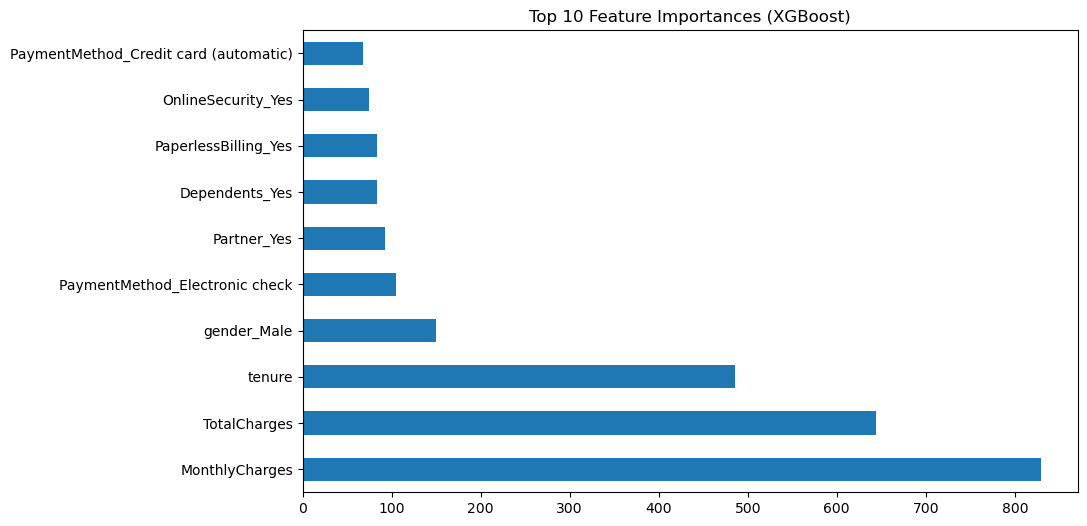

In [10]:
# Extract feature importances
importance = xgb_model.get_booster().get_score(importance_type='weight')
feature_importances = pd.Series(importance).sort_values(ascending=False).head(10)

print("\n--- Top 10 Feature Importances ---")
print(feature_importances)

# Optional: Plotting feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh', title='Top 10 Feature Importances (XGBoost)')
plt.show()

## Hyperparameter Tuning (Grid Search)

#### 1. Define Parameter Grid

In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import recall_score # Churn prediction mein Recall sabse important hai.

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],  # Number of boosting rounds
    'max_depth': [3, 5, 7],      # Maximum tree depth
    'learning_rate': [0.05, 0.1, 0.2], # Step size shrinkage
    'gamma': [0, 0.1],           # Minimum loss reduction required to make a further partition
}

# XGBoost model ko dobara initialize karein
# scale_pos_weight ko fix rakhenge kyunki yeh data ka property hai.
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count # approx 2.77

xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Use StratifiedKFold to maintain the Churn class ratio in each fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize GridSearchCV. Scoring metric ko 'recall' rakhenge.
grid_search = GridSearchCV(
    estimator=xgb_base, 
    param_grid=param_grid, 
    scoring='recall', # Focus on maximizing Churn Recall (Class 1)
    cv=cv, 
    verbose=1, 
    n_jobs=-1
)

print("Starting Grid Search...")
# Run the search on the training data
grid_search.fit(X_train, y_train)

print("\n--- Grid Search Results ---")
print(f"Best Recall Score found: {grid_search.best_score_:.4f}")
print(f"Best Parameters found: {grid_search.best_params_}")

Starting Grid Search...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

--- Grid Search Results ---
Best Recall Score found: 0.8012
Best Parameters found: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [15:53:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Final Model Training & Evaluation

In [20]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Best Parameters (Grid Search se mile hue)
# Parameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}

# scale_pos_weight (Training data se)
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count # approx 2.77

# Final XGBoost Model Initialize Best Parameters ke saath
# All parameters are passed manually to avoid the **best_params** syntax error.
xgb_final = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    
    # Manual Parameters
    gamma=0, 
    learning_rate=0.05, 
    max_depth=3, 
    n_estimators=200
) 

# Train the final model
print("Training Final Tuned XGBoost Model...")
xgb_final.fit(X_train, y_train)
print(" Final Tuned XGBoost Model successfully trained.")

# --- Evaluation Code ---
y_pred_final = xgb_final.predict(X_test)
print("\n--- Confusion Matrix (Tuned XGBoost) ---")
cm_final = confusion_matrix(y_test, y_pred_final)
print(cm_final)
print("\n--- Classification Report (Focus on Class 1: Churn) ---")
print(classification_report(y_test, y_pred_final))

Training Final Tuned XGBoost Model...


C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [16:03:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Final Tuned XGBoost Model successfully trained.

--- Confusion Matrix (Tuned XGBoost) ---
[[1121  431]
 [ 106  455]]

--- Classification Report (Focus on Class 1: Churn) ---
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1552
           1       0.51      0.81      0.63       561

    accuracy                           0.75      2113
   macro avg       0.71      0.77      0.72      2113
weighted avg       0.81      0.75      0.76      2113



## Final Conclusion: Optimized Customer Churn Prediction (XGBoost)

This project focused on identifying customers likely to churn using the Telco Customer Churn dataset. **Hyperparameter Tuning** (Grid Search) was utilized to achieve significant improvement in the **XGBoost** model's performance.

---

### 1. Model Performance Summary (After Tuning)

The initial model (Recall 0.67) was tuned using **Grid Search**. After training with the Best Parameters `{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}`, the following final metrics were obtained:

| Metric | Previous Model (Untuned) | **Tuned Final Model** |
| :--- | :--- | :--- |
| **Accuracy** | $0.76$ | **$0.75$** |
| **Recall (Churn - Class 1)** | $0.67$ | **$0.81$** |
| **Precision (Churn - Class 1)** | $0.54$ | **$0.51$** |

* **Key Improvement:** Churn **Recall increased from $0.67$ to $0.81$**. This means the model is now correctly identifying **$81\%$** of actual churning customers, which is the most crucial metric for business retention.
* **False Negatives:** Missed Churn cases (False Negatives) were **reduced from 187 to 106**.

---

### 2. Key Business Insights (Churn Drivers)

According to the Tuned model's **Feature Importance** , retention efforts should be concentrated on these factors:

* **Financial Factors:** **`MonthlyCharges`** (the Highest Driver) and low **`tenure`**.
* **Payment Risk:** The Payment Method **`Electronic check`** is strongly associated with the highest churn risk.

---

### 3. Business Recommendation

Leveraging the final model's high **Recall ($0.81$)**, the company should take immediate, targeted action on high-risk customers:

* **Targeted Incentives:** Offer customers with high Monthly Charges and Electronic Check payments **long-term contract discounts** or **Free Service Upgrades**.
* **A/B Testing:** A formal A/B Testing strategy is essential to measure the effectiveness of these targeted retention campaigns.